<a href="https://colab.research.google.com/github/zihadbappy/Machine-Learning-Projects/blob/master/DGL%2BStandard_Split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision.datasets.cifar import CIFAR10
import math
import datetime
import itertools
import time
import sys

# ==========================================
# 1. Utility Functions
# ==========================================

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# ==========================================
# 2. Model Definitions (Unchanged)
# ==========================================

class identity(nn.Module):
    def __init__(self):
        super(identity, self).__init__()
    def forward(self, input):
        return input

class DownsampleA(nn.Module):
    def __init__(self, nIn, nOut, stride):
        super(DownsampleA, self).__init__()
        assert stride == 2
        self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)

    def forward(self, x):
        x = self.avg(x)
        return torch.cat((x, x.mul(0)), 1)

class ResNetBasicblock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResNetBasicblock, self).__init__()
        self.conv_a = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn_a = nn.BatchNorm2d(planes)
        self.conv_b = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_b = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        basicblock = self.conv_a(x)
        basicblock = self.bn_a(basicblock)
        basicblock = F.relu(basicblock, inplace=True)
        basicblock = self.conv_b(basicblock)
        basicblock = self.bn_b(basicblock)
        if self.downsample is not None:
            residual = self.downsample(x)
        return F.relu(residual + basicblock, inplace=True)

class CifarResNet(object):
    def __init__(self, block, depth, num_classes):
        super(CifarResNet, self).__init__()
        assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
        layer_blocks = (depth - 2) // 6
        self.num_classes = num_classes
        self.layers = []
        self.conv_1_3x3 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.layers.append(self.conv_1_3x3)
        self.bn_1 = nn.BatchNorm2d(16)
        self.layers.append(self.bn_1)
        self.relu = nn.ReLU()
        self.layers.append(self.relu)
        list_planes = [16,] * layer_blocks + [32,] * layer_blocks + [64,] * layer_blocks
        list_stride = [1, 2, 2]
        self.inplanes = 16
        for i, planes in enumerate(list_planes):
            stride = 1
            downsample = None
            if i % layer_blocks == 0:
                stride = list_stride[i // layer_blocks]
                if stride != 1 or self.inplanes != planes * block.expansion:
                    downsample = DownsampleA(self.inplanes, planes * block.expansion, stride)
            self.layers.append(block(self.inplanes, planes, stride, downsample))
            if i % layer_blocks == 0:
                self.inplanes = planes * block.expansion
        self.avgpool = nn.AvgPool2d(8)
        self.layers.append(self.avgpool)
        self.classifier = nn.Linear(64 * block.expansion, num_classes)

class CifarResNetDDG(nn.Module):
    def __init__(self, model, layers, splits_id, num_splits, delay):
        super(CifarResNetDDG, self).__init__()
        self.splits_id = splits_id
        self.num_splits = num_splits
        self.layers = nn.Sequential(*layers)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None: m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight)

    def forward(self, x):
        x = self.layers(x)
        if self.splits_id == self.num_splits - 1:
            x = x.view(x.size(0), -1)
        return x

class auxillary_classifier2(nn.Module):
    def __init__(self, feature_size=256, input_features=256, in_size=32,
                 num_classes=10, n_lin=0, mlp_layers=0, batchn=True):
        super(auxillary_classifier2, self).__init__()
        self.n_lin = n_lin
        self.in_size = in_size
        self.mlp = mlp_layers > 0
        if n_lin == 0: feature_size = input_features
        current_input_features = input_features
        self.blocks = []
        for n in range(self.n_lin):
            if n == 0: in_f = current_input_features
            else: in_f = feature_size
            bn_temp = nn.BatchNorm2d(feature_size) if batchn else identity()
            conv = nn.Conv2d(in_f, feature_size, kernel_size=1, stride=1, padding=0, bias=False)
            self.blocks.append(nn.Sequential(conv, bn_temp))
        self.blocks = nn.ModuleList(self.blocks)
        self.bn = nn.BatchNorm2d(feature_size) if batchn else identity()

        if mlp_layers > 0:
            mlp_feat = feature_size * 2 * 2
            layers = []
            for l in range(mlp_layers):
                if l == 0: in_feat = feature_size * 4
                else: in_feat = mlp_feat
                bn_temp = nn.BatchNorm1d(mlp_feat) if batchn else identity()
                layers += [nn.Linear(in_feat, mlp_feat), bn_temp, nn.ReLU(True)]
            layers += [nn.Linear(mlp_feat, num_classes)]
            self.classifier = nn.Sequential(*layers)
        else:
            self.classifier = nn.Linear(feature_size * 2 * 2, num_classes)

    def forward(self, x):
        out = x
        out = F.adaptive_avg_pool2d(out, (math.ceil(self.in_size / 4), math.ceil(self.in_size / 4)))
        for n in range(self.n_lin):
            out = self.blocks[n](out)
            out = F.relu(out)
        out = F.adaptive_avg_pool2d(out, (2, 2))
        if not self.mlp: out = self.bn(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

class rep(nn.Module):
    def __init__(self, blocks):
        super(rep, self).__init__()
        self.blocks = blocks
    def forward(self, x, n, upto=False):
        if upto:
            for i in range(n + 1):
                x = self.forward(x, i, upto=False)
            return x
        out = self.blocks[n](x)
        return out

class Net(nn.Module):
    def __init__(self, depth=110, num_classes=10, num_splits=2):
        super(Net, self).__init__()
        self.blocks = nn.ModuleList([])
        self.auxillary_nets = nn.ModuleList([])
        model = CifarResNet(ResNetBasicblock, depth, num_classes)
        len_layers = len(model.layers)
        split_depth = math.ceil(len_layers / num_splits)

        for splits_id in range(num_splits):
            left_idx = splits_id * split_depth
            right_idx = (splits_id + 1) * split_depth
            if right_idx > len_layers: right_idx = len_layers

            # Create Split Block
            net = CifarResNetDDG(model, model.layers[left_idx:right_idx], splits_id, num_splits, num_splits - 1 - splits_id)
            self.blocks.append(net)

            # Create Aux Net or Final Classifier
            if splits_id < num_splits - 1:
                self.auxillary_nets.append(
                    auxillary_classifier2(input_features=32, in_size=16, num_classes=num_classes, n_lin=3, mlp_layers=3))
            else:
                self.auxillary_nets.append(model.classifier)

        self.main_cnn = rep(self.blocks)

    def forward(self, representation, n, upto=False):
        representation = self.main_cnn.forward(representation, n, upto=upto)
        outputs = self.auxillary_nets[n](representation)
        return outputs, representation

# ==========================================
# 3. Training & Validation Logic
# ==========================================

def validate(val_loader, model, criterion, epoch, device, mode):
    losses = AverageMeter()
    top1 = AverageMeter()
    model.eval()
    last_split_idx = len(model.main_cnn.blocks) - 1

    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            outputs, _ = model(input, n=last_split_idx, upto=True)
            loss = criterion(outputs, target)
            prec1 = accuracy(outputs, target)
            losses.update(loss.item(), input.size(0))
            top1.update(prec1[0].item(), input.size(0))

    return top1.avg, losses.avg

def train_dgl_bp_free(train_loader, model, criterion, optimizers, device):
    model.train()
    ncnn = len(model.main_cnn.blocks)
    losses = [AverageMeter() for _ in range(ncnn)]
    top1 = [AverageMeter() for _ in range(ncnn)]

    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        representation = inputs

        for n in range(ncnn):
            optimizers[n].zero_grad()
            outputs, representation = model(representation, n=n)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizers[n].step()
            representation = representation.detach()

            prec1 = accuracy(outputs, targets)
            losses[n].update(loss.item(), inputs.size(0))
            top1[n].update(prec1[0].item(), inputs.size(0))

    return losses[-1].avg, top1[-1].avg

def train_standard_split(train_loader, model, criterion, optimizer, device):
    model.train()
    ncnn = len(model.main_cnn.blocks)
    last_split_idx = ncnn - 1
    losses = AverageMeter()
    top1 = AverageMeter()

    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        representation = inputs

        for n in range(ncnn):
            if n == last_split_idx:
                # The final call uses Net.forward(), which returns (outputs, representation)
                outputs, representation = model(representation, n=n)
            else:
                # Intermediate calls use rep.forward(), which returns ONLY representation
                # FIX: Removed "_, " unpacking here
                representation = model.main_cnn(representation, n=n)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        prec1 = accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1[0].item(), inputs.size(0))

    return losses.avg, top1.avg

# ==========================================
# 4. Main Execution
# ==========================================

parser = argparse.ArgumentParser(description='PyTorch CIFAR-10 DGL vs Standard Split Learning')
parser.add_argument('--batch-size', type=int, default=256, metavar='N', help='Input batch size')
parser.add_argument('--test-batch-size', type=int, default=256, metavar='N', help='Test batch size')
parser.add_argument('--epochs', type=int, default=40, metavar='N', help='Number of epochs')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR', help='Learning rate')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='Random seed')

def main():
    # Pass empty list for notebooks
    args = parser.parse_args([])

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Device: {device}")

    # Reproducibility
    torch.manual_seed(args.seed)
    if use_cuda:
        torch.cuda.manual_seed(args.seed)
        cudnn.benchmark = True

    # Data
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=use_cuda)
    testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=4, pin_memory=use_cuda)

    # MODES TO RUN
    modes = ['dgl', 'standard']
    results = {}

    for mode in modes:
        print("\n" + "="*60)
        print(f" STARTING MODE: {mode.upper()} ")
        print("="*60)

        # Reset Model and Optimizer for each mode
        model = Net(depth=110, num_classes=10, num_splits=2).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        ncnn = len(model.main_cnn.blocks)

        # Setup Optimizers
        optimizers = []
        optimizer = None

        if mode == 'dgl':
            for n in range(ncnn):
                params = itertools.chain(model.main_cnn.blocks[n].parameters(), model.auxillary_nets[n].parameters())
                optimizers.append(optim.SGD(params, lr=args.lr, momentum=0.9, weight_decay=5e-4))
        else:
            params = list(model.main_cnn.parameters()) + list(model.auxillary_nets[-1].parameters())
            optimizer = optim.SGD(params, lr=args.lr, momentum=0.9, weight_decay=5e-4)

        # Training Loop
        best_acc = 0
        start_time_total = time.time()

        print(f"{'Epoch':<6} | {'Time':<6} | {'Train Loss':<10} | {'Train Acc':<10} | {'Val Acc':<10}")
        print("-" * 55)

        for epoch in range(1, args.epochs + 1):
            epoch_start = time.time()

            # LR Scheduler
            if epoch in [25, 30]:
                decay = 0.1
                if mode == 'dgl':
                    for opt in optimizers:
                        for pg in opt.param_groups: pg['lr'] *= decay
                else:
                    for pg in optimizer.param_groups: pg['lr'] *= decay

            # Train
            if mode == 'dgl':
                trn_loss, trn_acc = train_dgl_bp_free(train_loader, model, criterion, optimizers, device)
            else:
                trn_loss, trn_acc = train_standard_split(train_loader, model, criterion, optimizer, device)

            # Validate
            val_acc, val_loss = validate(val_loader, model, criterion, epoch, device, mode)

            epoch_time = time.time() - epoch_start
            best_acc = max(best_acc, val_acc)

            print(f"{epoch:<6} | {epoch_time:.1f}s  | {trn_loss:.4f}     | {trn_acc:.2f}%     | {val_acc:.2f}%")

        total_time = time.time() - start_time_total
        results[mode] = {'best_acc': best_acc, 'total_time': total_time}

        # Cleanup to save memory for next run
        del model
        torch.cuda.empty_cache()

    # Final Summary
    print("\n\n" + "="*40)
    print(" FINAL RESULTS SUMMARY ")
    print("="*40)
    print(f"{'Mode':<15} | {'Best Accuracy':<15} | {'Total Time':<15}")
    print("-" * 50)
    for mode in modes:
        print(f"{mode.upper():<15} | {results[mode]['best_acc']:.2f}%          | {results[mode]['total_time']:.1f}s")
    print("="*40)

if __name__ == '__main__':
    main()

Device: cuda

 STARTING MODE: DGL 
Epoch  | Time   | Train Loss | Train Acc  | Val Acc   
-------------------------------------------------------
1      | 16.7s  | 3.4027     | 11.38%     | 14.63%
2      | 16.1s  | 2.2569     | 13.37%     | 16.84%
3      | 16.1s  | 1.9652     | 20.12%     | 22.03%
4      | 16.3s  | 1.7344     | 29.99%     | 33.28%
5      | 16.2s  | 1.4434     | 44.47%     | 41.30%
6      | 16.1s  | 1.2599     | 52.97%     | 48.93%
7      | 16.2s  | 1.1434     | 58.09%     | 46.43%
8      | 16.1s  | 1.0421     | 62.51%     | 57.82%
9      | 15.9s  | 0.9592     | 66.26%     | 51.46%
10     | 16.1s  | 0.8736     | 69.92%     | 66.19%
11     | 16.0s  | 0.7722     | 73.78%     | 66.32%
12     | 15.9s  | 0.7178     | 75.59%     | 62.57%
13     | 16.0s  | 0.6748     | 76.92%     | 70.87%
14     | 15.9s  | 0.6335     | 78.40%     | 67.25%
15     | 16.2s  | 0.6166     | 79.03%     | 63.52%
16     | 15.9s  | 0.5971     | 79.72%     | 70.97%
17     | 16.0s  | 0.5898     | 80.02% 

In [3]:
print("hi")

hi


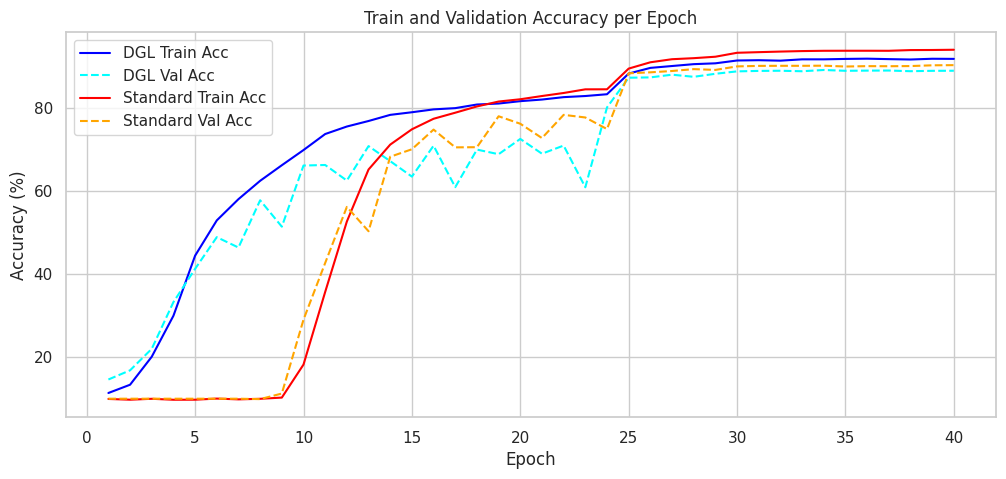

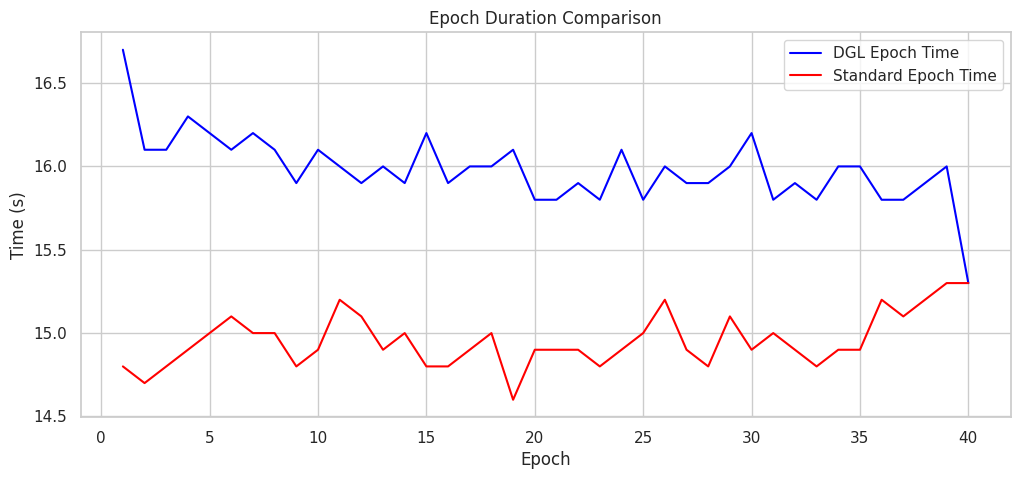

/tmp/ipython-input-1918826111.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modes, y=best_acc, palette=['blue', 'red'])


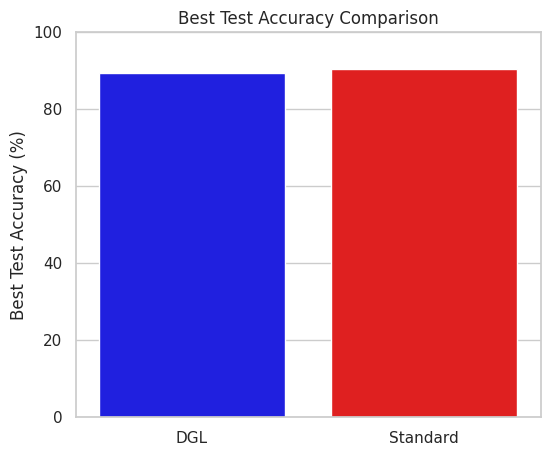

/tmp/ipython-input-1918826111.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modes, y=total_time, palette=['blue', 'red'])


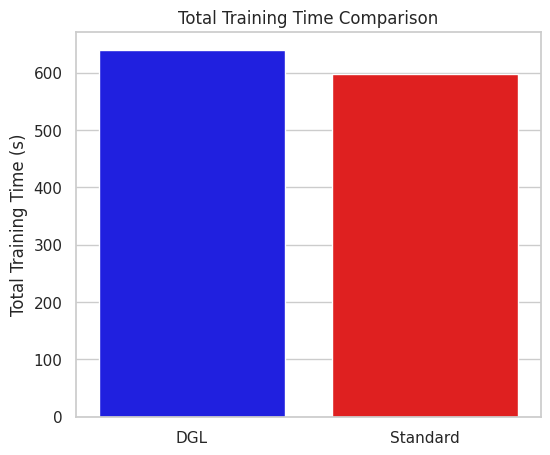

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")

# ==========================================
# Extract per-epoch metrics from logs
# ==========================================

epochs = np.arange(1, 41)

# DGL
dgl_train_acc = [
    11.38, 13.37, 20.12, 29.99, 44.47, 52.97, 58.09, 62.51, 66.26, 69.92,
    73.78, 75.59, 76.92, 78.40, 79.03, 79.72, 80.02, 80.89, 81.13, 81.70,
    82.09, 82.67, 82.94, 83.37, 88.35, 89.72, 90.17, 90.62, 90.82, 91.50,
    91.57, 91.46, 91.78, 91.78, 91.88, 91.94, 91.83, 91.74, 91.92, 91.89
]

dgl_val_acc = [
    14.63, 16.84, 22.03, 33.28, 41.30, 48.93, 46.43, 57.82, 51.46, 66.19,
    66.32, 62.57, 70.87, 67.25, 63.52, 70.97, 60.98, 70.03, 68.92, 72.60,
    69.04, 71.00, 60.95, 80.19, 87.35, 87.43, 88.08, 87.57, 88.30, 88.88,
    88.99, 89.03, 88.91, 89.21, 89.02, 89.06, 89.08, 88.92, 89.01, 89.03
]

dgl_epoch_time = [
    16.7, 16.1, 16.1, 16.3, 16.2, 16.1, 16.2, 16.1, 15.9, 16.1, 16.0, 15.9,
    16.0, 15.9, 16.2, 15.9, 16.0, 16.0, 16.1, 15.8, 15.8, 15.9, 15.8, 16.1,
    15.8, 16.0, 15.9, 15.9, 16.0, 16.2, 15.8, 15.9, 15.8, 16.0, 16.0, 15.8,
    15.8, 15.9, 16.0, 15.3
]

# STANDARD
std_train_acc = [
    9.94, 9.76, 9.98, 9.75, 9.76, 10.03, 9.84, 9.98, 10.27, 18.23,
    35.73, 52.70, 65.23, 71.23, 74.92, 77.46, 78.92, 80.43, 81.61, 82.16,
    82.94, 83.67, 84.55, 84.56, 89.55, 91.07, 91.81, 92.06, 92.41, 93.36,
    93.51, 93.65, 93.77, 93.84, 93.85, 93.85, 93.84, 94.01, 94.03, 94.09
]

std_val_acc = [
    10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 9.90, 11.25, 29.05,
    42.71, 56.22, 50.36, 68.31, 70.11, 74.85, 70.57, 70.61, 78.06, 76.26,
    72.81, 78.40, 77.77, 74.98, 88.42, 88.65, 88.97, 89.42, 89.23, 90.08,
    90.20, 90.22, 90.22, 90.25, 90.05, 90.14, 90.12, 90.16, 90.34, 90.38
]

std_epoch_time = [
    14.8, 14.7, 14.8, 14.9, 15.0, 15.1, 15.0, 15.0, 14.8, 14.9,
    15.2, 15.1, 14.9, 15.0, 14.8, 14.8, 14.9, 15.0, 14.6, 14.9,
    14.9, 14.9, 14.8, 14.9, 15.0, 15.2, 14.9, 14.8, 15.1, 14.9,
    15.0, 14.9, 14.8, 14.9, 14.9, 15.2, 15.1, 15.2, 15.3, 15.3
]

# ==========================================
# 1. Plot train vs val accuracy per model
# ==========================================

plt.figure(figsize=(12,5))
plt.plot(epochs, dgl_train_acc, label='DGL Train Acc', color='blue')
plt.plot(epochs, dgl_val_acc, label='DGL Val Acc', color='cyan', linestyle='--')
plt.plot(epochs, std_train_acc, label='Standard Train Acc', color='red')
plt.plot(epochs, std_val_acc, label='Standard Val Acc', color='orange', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy per Epoch')
plt.legend()
plt.show()

# ==========================================
# 2. Plot epoch time comparison
# ==========================================
plt.figure(figsize=(12,5))
plt.plot(epochs, dgl_epoch_time, label='DGL Epoch Time', color='blue')
plt.plot(epochs, std_epoch_time, label='Standard Epoch Time', color='red')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Epoch Duration Comparison')
plt.legend()
plt.show()

# ==========================================
# 3. Bar chart of final best test accuracy
# ==========================================
best_acc = [89.21, 90.38]  # From final results summary
modes = ['DGL', 'Standard']

plt.figure(figsize=(6,5))
sns.barplot(x=modes, y=best_acc, palette=['blue', 'red'])
plt.ylabel('Best Test Accuracy (%)')
plt.title('Best Test Accuracy Comparison')
plt.ylim(0,100)
plt.show()

# ==========================================
# 4. Total training time comparison
# ==========================================
total_time = [639.6, 598.4]  # From final results summary

plt.figure(figsize=(6,5))
sns.barplot(x=modes, y=total_time, palette=['blue', 'red'])
plt.ylabel('Total Training Time (s)')
plt.title('Total Training Time Comparison')
plt.show()
